<a href="https://colab.research.google.com/github/KenjiPrayogo/ML-Capstone/blob/main/Soil_prediction_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pathlib

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-30 10:47:32--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   106MB/s    in 0.8s    

2023-05-30 10:47:33 (106 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# Set the path to the image dataset folder
dataset_path = '/content/drive/MyDrive/Tanah'



In [4]:
# Define the class labels
class_labels = ['01-Aluvial', '02-Andosol', '03-Entisol', '04-Humus', '05-Inceptisol', '06-Laterit', '07-Kapur', '08-Pasir']
num_classes = len(class_labels)


# Data preprocessing
data = []
labels = []
for i, class_label in enumerate(class_labels):
    class_folder_path = os.path.join(dataset_path, class_label)
    for image_name in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_name)
        image = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image_array = keras.preprocessing.image.img_to_array(image)
        data.append(image_array)
        labels.append(i)



In [5]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape= (224,224,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(8, activation='softmax')(x)


#Append the dense network to the base model
model = Model( pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
model.summary()

In [11]:
# Normalize the image data
data = data / 255.0

# Split the dataset into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


In [12]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(train_data)

In [13]:
history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=17),
                    steps_per_epoch=len(train_data) // 17,
                    epochs=50,
                    validation_data=(val_data, val_labels))

Epoch 1/50
41/41 [==============================] - 27s 310ms/step - loss: 7.8793 - accuracy: 0.3406 - val_loss: 1.5396 - val_accuracy: 0.5057
Epoch 2/50
41/41 [==============================] - 8s 186ms/step - loss: 1.1380 - accuracy: 0.6201 - val_loss: 0.6734 - val_accuracy: 0.8182
Epoch 3/50
41/41 [==============================] - 8s 199ms/step - loss: 0.7583 - accuracy: 0.7336 - val_loss: 0.5217 - val_accuracy: 0.8409
Epoch 4/50
41/41 [==============================] - 9s 226ms/step - loss: 0.5322 - accuracy: 0.8151 - val_loss: 0.5513 - val_accuracy: 0.8011
Epoch 5/50
41/41 [==============================] - 8s 191ms/step - loss: 0.5848 - accuracy: 0.8049 - val_loss: 0.3647 - val_accuracy: 0.8864
Epoch 6/50
41/41 [==============================] - 8s 190ms/step - loss: 0.3973 - accuracy: 0.8603 - val_loss: 0.2937 - val_accuracy: 0.9091
Epoch 7/50
41/41 [==============================] - 8s 201ms/step - loss: 0.4219 - accuracy: 0.8544 - val_loss: 0.2538 - val_accuracy: 0.9091
Epoch

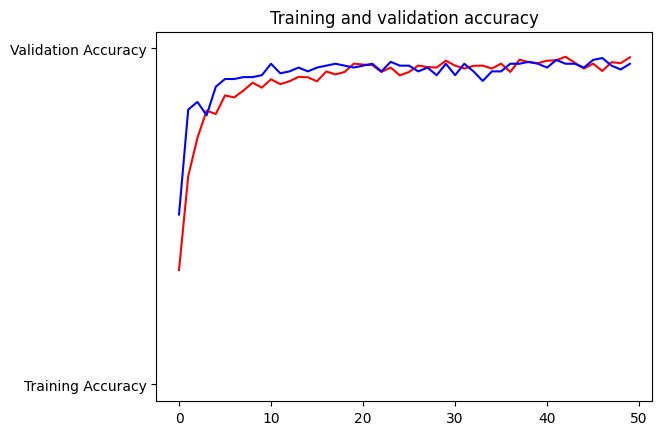

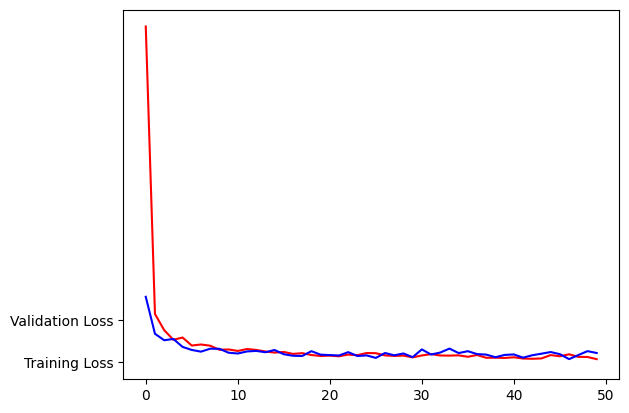

In [14]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
 # predicting images
  path = '/tmp/images/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  print("Predicted Label:", predicted_label)
  print(path)
  #print("Prediction Scores:", classes)
  

['laterit-014.jpg', 'aluvial3.jpg.webp', 'shutterstock_389823613.jpg', 'entisol-085.jpg', 'andosol-060.jpg', 'glen-carrie-ib1jujyqob4-unsplash-easy-resizecom-1b6d1cd853484267ae86171b72dde9ea-203cacbc16e5ed7f1ba584dace0e1f12_600x400.jpg', 'soil-profile-Inceptisol-accumulation-humus-clay-minerals.jpg.webp', 'pasir-044.jpg', 'entisol-094.jpg', 'entisol-109.jpg', 'kapur-015.jpg', 'kapur-002.jpg', 'laterit-007.jpg', 'kapur-093.jpg', 'aluvial.jpg', 'entisol-079.jpg', 'istockphoto-1206172322-1024x1024.jpg', 'fresh-2386786-1920_ver_1.jpg', 'inceptisol-002.jpg', 'aluvial2.jpg', 'tanah-aluvial.jpg', 'humus-026.jpg', 'aluvial-100.jpg', 'image5.jpg', 'kapur-005.jpg', 'inceptisol-099.jpg', 'inceptisol-038.jpg', 'tanah-podsol.jpg', 'laterit-010.jpg', '2.-Ciri-Tanah-Aluvial-Proses-Terbentuknya-Hingga-Manfaat-Untuk-Pertanian.jpg']

1/1 [==============================] - 0s 47ms/step
Predicted Label: 06-Laterit
/tmp/images/laterit-014.jpg

1/1 [==============================] - 0s 39ms/step
Predicted L

In [ ]:
# Save model weights and architecture
model.save_weights('/content/drive/MyDrive/saved_models/model_weights.h5')
model.save('/content/drive/MyDrive/saved_models/model_saved.h5')


In [2]:
from tensorflow.keras.models import load_model

# Load model architectur
loaded_model = load_model('/content/drive/MyDrive/saved_models/model_saved.h5')

# Load model weights
loaded_model.load_weights('/content/drive/MyDrive/saved_models/model_weights.h5')


In [5]:
export = '/content/drive/MyDrive/saved_models/saved_model'
tf.saved_model.save(model, export)

NameError: ignored

In [16]:
# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [optimization]
tflite_model = converter.convert();


NameError: ignored

In [3]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

NameError: ignored

In [ ]:
prediction = loaded_model.predict()

In [ ]:
 # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
 # predicting images
  path = '/tmp/images/' + i
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = loaded_model.predict(images, batch_size=10)
  pred = np.argmax(classes, axis=-1)
  predicted_label = class_labels[pred[0]]

  print("Predicted Label:", predicted_label)
  print(path)
  #print("Prediction Scores:", classes)
  

FileNotFoundError: ignored